# Matrix Inversion with Quantum Singular Value Transform (QSVT)

> **Quantum Matrix Inversion (or Quantum Linear Solver) via QSVT** provides a framework for solving linear systems exponentially faster than known classical methods under certain conditions [\[1\]](#ref-grand). The algorithm employs a polynomial transformation of singular values to block-encode the inverse of a matrix, which can then be applied on a prepared quantum state to solve a linear equation. Given an efficient routine to embed the classical matrix as a quantum function (block-encoding), this algorithm gives a clean and optimal way to implement matrix inversion compared to other quantum methods. Quantum linear solvers based on block-encoding have many applications, e.g., in [Plasma Physics](https://github.com/Classiq/classiq-library/blob/main/applications/plasma/vlasov_ampere/vlasov_ampere.ipynb) and [Fluid Dynamics](https://github.com/Classiq/classiq-library/blob/main/applications/cfd/linear_qls_for_hybrid_solvers/qls_qsvt.ipynb).
>
> - **Input:** An $N \times N$ matrix $A$ with condition number $\kappa$ (the ratio between the maximal and minimal singular values), and a vector $|b\rangle$ prepared as a quantum state.
> - **Promise:** The matrix $A$ is well-conditioned (invertible, with bounded spectrum) and can be efficiently block-encoded in a unitary $U_A$ (see technical note at the end of this demo).
> - **Output:** A quantum state proportional to $|x\rangle = A^{-1} |b\rangle$, encoding the solution of the linear system $A x = b$.
>
> **Complexity:** Using QSVT, matrix inversion requires $O(\kappa \log(\kappa / \epsilon))$ queries of the block-encoding unitary, where $\epsilon$ is the precision parameter. Typically, an efficient block-encoding scales as $\mathrm{poly}(\log N)$, resulting in an overall $\tilde{O}(\kappa \,\mathrm{polylog}(N, 1 / \epsilon))$ complexity for the QSVT linear solver. This improves exponentially in $\epsilon$ upon the original Harrow–Hassidim–Lloyd ([HHL](https://github.com/Classiq/classiq-library/blob/main/algorithms/hhl/hhl/hhl.ipynb)) algorithm, and exponentially in $N$ compared to classical linear solvers, while matching known lower bounds for quantum linear solvers [<a href=#ref-childs>2</a>].
>
> (As with all quantum linear solvers, extracting the full solution state $|x\rangle$ removes the speedup; the advantage arises when only global properties such as expectation values, overlaps, or samples are required.)
>
> ---
>
> **Keywords:** Linear systems, Quantum Singular Value Transformation (QSVT), Block encoding, Matrix inversion, Exponential speedup, Oracle/Query complexity.


In this demo we will restrict ourselves to matrices of size $N\times N$, with $N=2^n$. A generalization to arbitrary $N$ can be done by completing the matrix into a larger one, or modifying the QSVT routine to an arbitrary $N$. We emphasize that compared to the basic HHL algorithm, the QSVT approach *is not restricted to Hermitian matrices*.

The QSVT algorithm is based on the idea of block-encoding a matrix into a larger unitary:
$$
U_{(A,s)} = \begin{pmatrix}
A/s & * \\
* & *
\end{pmatrix}, \tag{1}
$$
where $s$ is some scaling factor, which is sometimes necessary for this unitarity completion.
Given an access to $U_{(A,s)}$, matrix inversion with QSVT implements a block-encoding for the inverse of $A$
$$
U_{(A^{-1},s')} = \begin{pmatrix}
A^{-1}/s' & * \\
* & *
\end{pmatrix}.
$$
Subsequently, we can use this unitary to solve a linear system, $A|x\rangle = |b\rangle$, by applying it on an initially prepared state $|b\rangle_n|0\rangle_{\rm block}$
(the state $|0\rangle_{\rm block}$ identifies the block in which the matrix is encoded). Up to post-selection we have: 
$$
U_{(A^{-1},s')} |b\rangle_n|0\rangle_{\rm block} = \frac{A^{-1}}{s'}|b\rangle_n|0\rangle_{\rm block} + \text{ garbage}.
$$

In more detail, Singular Value Decomposition (SVD) of a matrix $A$ is defined by
$$
A = W\Sigma V^\dagger,
$$
where $W$ and $V$ are unitary matrices, and $\Sigma$ is a diagonal matrix that contains the singular values of $A$ (The square root of the eigenvalues of $A A^{\dagger}$). A singular value polynomial transform refers to 
$$
\mathrm{Poly}^{\rm (SV)}(A) = \left\{\begin{array}{l l} 
W\mathrm{Poly}(\Sigma) V^\dagger, & \text{ for odd polynomial} \\
V\mathrm{Poly}(\Sigma) V^\dagger, & \text{ for even polynomial}
\end{array}
\right . \,\,,
$$
where $\mathrm{Poly(\sigma)}$ is a polynomial with a well-defined parity. The QSVT routine allows to block-encode such singular value polynomial transforms, based on the Quantum Signal Processing (QSP) approach. For the case of matrix inversion, we have the identities,
$$
\begin{align}
A^\dagger &=V^\dagger \Sigma W,\\
A^{-1} &= V^\dagger \Sigma^{-1}W,
\end{align}
$$
from which we can deduce that: 

**Applying a QSVT of an odd polynomial that approximates $\mathrm{Poly(\sigma)}\sim 1/\sigma$, on the block-encoding of $A^{\dagger}$, gives the matrix inversion of $A$.**


Below we demonstrate how to implement a quantum linear solver for a specific problem. As we will see, the input of the algorithm is block-encoding of the matrix $A$, and its effective condition number $(\sigma_{\min}/s)^{-1}$, with $\sigma_{\min}$ being the minimal singular eigenvalue. Using the `qsvt_inversion` function from the open-library and some classical auxiliary functions from our `qsp` application, allow to easily implement the algorithm, given those two inputs.

## Example: Block-encoded matrix in a random unitary

In [1]:
!pip install -qq "classiq[qsp]"

### Setting an Example

We start by defining a specific problem: a matrix, its block encoding, and its condition number. We take a very simple usecase: define a random unitary of size $2^{n+1}$, taking its upper $2^n\times 2^n$ block as the block-encoded matrix $A$ that we want to invert.

In [1]:
import numpy as np
import scipy

# the size of the unitary which block encodes A
REG_SIZE = 3


def get_random_unitary(num_qubits, seed=4):
    np.random.seed(seed)
    X = np.random.rand(2**num_qubits, 2**num_qubits)
    U, s, V = np.linalg.svd(X)
    return U @ V.T


U_a = get_random_unitary(REG_SIZE)

A_dim = int(U_a.shape[0] / 2)
A = U_a[:A_dim, :A_dim]
print(A)

[[-0.05338002 -0.36103662 -0.54016489 -0.39026125]
 [-0.33304121  0.10648228  0.37346704 -0.33977916]
 [ 0.4167817  -0.75180519  0.17593867  0.20944773]
 [ 0.26891079 -0.05333795 -0.32668787 -0.33602829]]


Make sure the singular values for A are smaller than 1, and verify that $U_{A}$ is indeed unitary:

In [2]:
assert not (np.linalg.svd(A)[1] > 1).sum()
assert np.allclose(U_a @ U_a.T, np.eye(U_a.shape[0]), rtol=1e-5, atol=1e-6)

### Block-encoding

Next, we define the quantum functions required for the algortihm. It is instructive to work with a `QSrtuct` to represent the quantum variable for the block-encoding.

In [3]:
from classiq import *


class QsvtState(QStruct):
    state: QNum[REG_SIZE - 1]
    block: QBit

In addition, we define two quantum functions that we shall pass to the QSVT routine: a function that reflects about `block` at state zero, which identify the block in which the matrix is encoded, and a function that block encodes our matrix.
(Recall that for inversion we shall block-encode $A^{\dagger}$. However, the `qsvt_inversion` function handles this internally, by passing the inverse $U^{\dagger}_{A}=U_{A^\dagger}$).

In [4]:
# Define QSVT projector


@qfunc
def projector(be: QsvtState, res: QBit):
    res ^= be.block == 0


@qfunc
def be_qfunc(qsvt_state: QsvtState):
    unitary(elements=U_a.tolist(), target=qsvt_state)

As explained below, we need to evaluate an effective condition number, $\kappa=s/\min(\sigma_i)$ (this parameter is bounded by the actual condition number $\max{(\sigma_i)}/\min(\sigma_i)$; see technical note at the end of this notebook).
In real life, this value is not known and needs to be approximated by some prior knowledge of the problem, or through some classical method. In our small example we will just explicitly compute the SVD decomposition of $A$:

In [5]:
svd = np.linalg.svd(A)[1]
# In our simple usecase s=1
s = 1
kappa = s / min(svd)
print(f"The effective condition number is {kappa}")

The effective condition number is 3.4598628384708703


### Finding QSVT angles for the approximated inverse function

We need to find a polynomial approximation to the $\frac{1}{x}$ function. Notice that the function is exploding as $x$ goes to 0, which breaks the rules for the existence of QSP polynomial, which must be bounded by 1 in $[-1,1]$. However, we can limit the polynomial to approximate only at the relevant range  $[\sigma_{\min}/s, \sigma_{\max}/s]$, i.e., in the interval that contains the singular values of the block-encoded matrix. The target function we need to approximate is thus:
$$
f(x) = \frac{1}{2}\frac{1}{\kappa x}, \qquad x\in [\sigma_{min}, \sigma_{max}],
$$
where $\kappa=s/\sigma_{min}$ as defined below, and a scaling factor of 1/2 was added to get an easier convergence for the corresponding QSVT angles. We can see that $|f(x)|\leq 1$ in the relevant range.

According to Ref. [<a href="#ref-childs">2</a>], a degree of $\sim \kappa \log(\kappa/\epsilon)$ is sufficient to approximate $f(x)$ with an error $\epsilon$. Below, we use the `qsp_approximate` function to get the approximated polynomial. This function approximates $f(x)$ as a sum of Chebyshev polynomials, making sure the resulting polynomial is bounded by 1 in the *entire range* $[-1, 1]$. Subsequently, we call the `qsvt_phases` to get the corresponding QSVT phases.

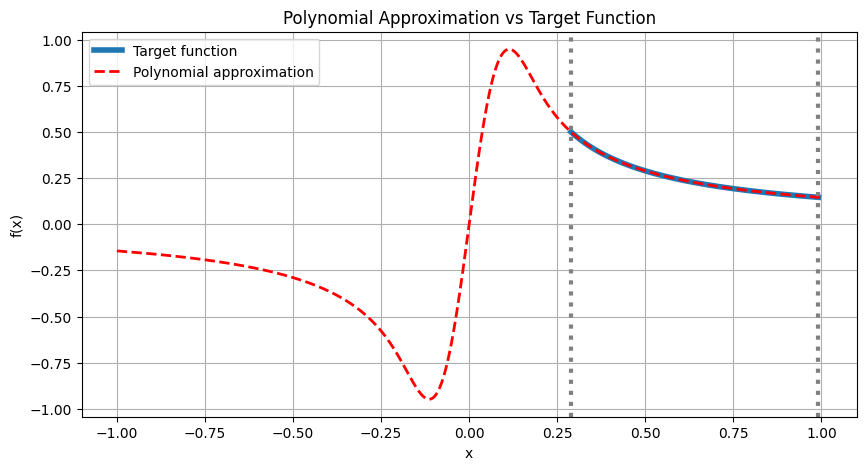

In [6]:
from classiq.applications.qsp import qsp_approximate, qsvt_phases

EPS = 1e-8
degree = int(kappa * np.log(kappa / EPS))
# In case we provide an even degree and ask for an odd polynimial
if degree % 2 == 0:
    degree += 1

SCALE = 0.5


def target_function(x):
    return SCALE * 1 / (kappa * x)


pcoefs, opt_res = qsp_approximate(
    target_function, degree=degree, parity=1, interval=[min(svd), max(svd)], plot=True
)

inversion_phases = qsvt_phases(pcoefs)

The interpolating function returns the coefficients, as well as the approximated maximum error between the target function and the approximating polynomial within the interval.

In [7]:
print(
    f"For the function {np.round(SCALE/kappa,5)}1/x, we approximate with an odd polynomial of degree {degree} with an error of {opt_res}"
)

For the function 0.144511/x, we approximate with an odd polynomial of degree 69 with an error of 4.707465528497323e-09


### Solving a linear equation

Next, we solve an instance of a linear equation $A\vec{x} = \vec{b}$. For this, we define some arbitrary $\vec{b}$ vector.

In [8]:
b = np.arange(A_dim)
b_norm = np.linalg.norm(b)
b_normalized = (b / b_norm).tolist()
print(b)

[0 1 2 3]


Now, we build the quantum model, preparing the initial state and then calling `qsvt_inversion` with the parameters defining our specific problem:

In [9]:
@qfunc
def main(
    qsvt_state: Output[QsvtState],
    qsvt_aux: Output[QBit],
) -> None:

    allocate(qsvt_aux)
    allocate(qsvt_state)
    inplace_prepare_amplitudes(b_normalized, 0, qsvt_state.state)

    qsvt_inversion(
        phase_seq=inversion_phases,
        block_encoding_cnot=lambda aux: projector(qsvt_state, aux),
        u=lambda: be_qfunc(qsvt_state),
        aux=qsvt_aux,
    )


write_qmod(main, "qsvt_matrix_inversion", decimal_precision=12)

Let us synthesize, visualize, and execute. For the execution, we choose a statevector simulator, as we are considering a small problem for demonstrating the algorithm. In addition, later on we would like to verify our result against the expected classical one.

In [11]:
qprog = synthesize(main)
show(qprog)

execution_preferences = ExecutionPreferences(
    num_shots=1,
    backend_preferences=ClassiqBackendPreferences(
        backend_name=ClassiqSimulatorBackendNames.SIMULATOR_STATEVECTOR
    ),
)

with ExecutionSession(qprog, execution_preferences) as es:
    # Currently, filtering is possible for QBit and QNum, but not for QStruct
    es.set_measured_state_filter("qsvt_aux", lambda state: state == 0.0)
    result = es.sample()

Quantum program link: https://platform.classiq.io/circuit/35YjqMigetKATtz2myYGsDMwvie


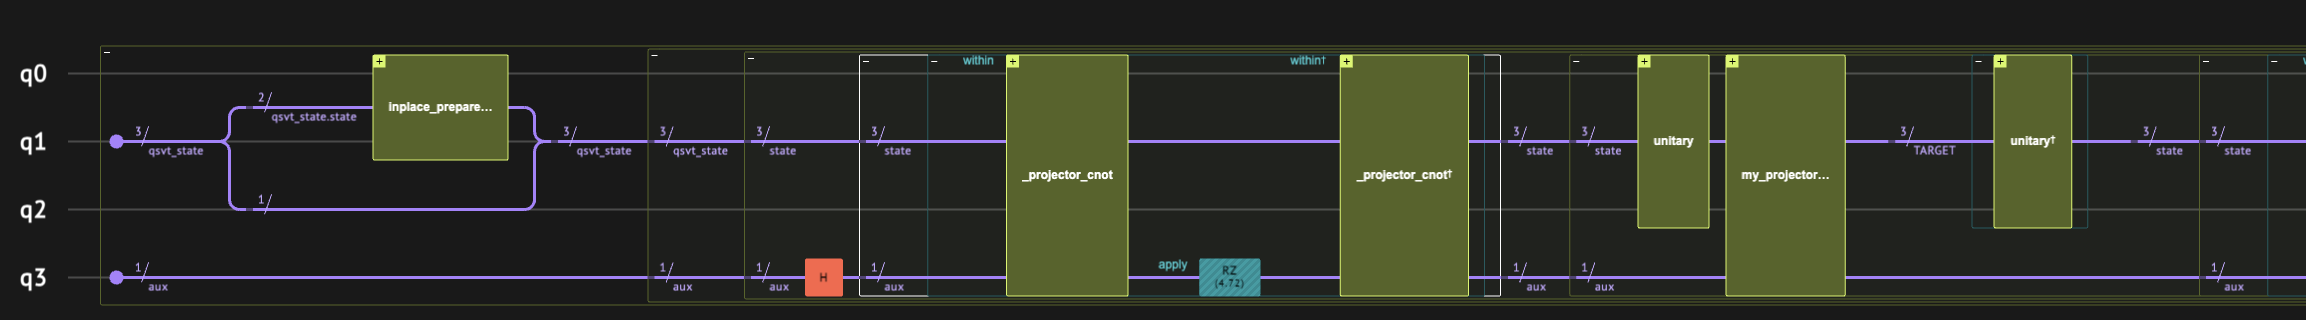

If our matrix $A$ is block-encoded with a block variable of size $m$, then the QSVT routine block encodes the inverse of $A$ on $m+1$ qubits, where the additional qubit is the `qsvt_aux`. Therefore, we need to post-select on `qsvt_state.block` and `qsvt_aux` being zero, if we want to obtain a state $\sim A^{-1}|b\rangle$. Note that the additional block qubit was already filtered as part of the execution call.

In [17]:
df = result.dataframe
df_filtered = df[(df["qsvt_state.block"] == 0)].sort_values("qsvt_state.state")
df_filtered

,qsvt_state.state,qsvt_state.block,qsvt_aux,amplitude,magnitude,phase,probability,bitstring
7,0,0,0,-0.184047-0.225847j,0.29,-0.72π,0.084880,0000
5,1,0,0,-0.013748-0.016870j,0.02,-0.72π,0.000474,0010
6,2,0,0,-0.084568-0.103776j,0.13,-0.72π,0.017921,0100
0,3,0,0,0.154944+0.190135j,0.25,0.28π,0.060159,0110


### Comparing to the expected result

Finally, we verify our quantum solution, by comparing it to the expected classical one.

In [13]:
expected_x = np.linalg.inv(A) @ b

The quantum routine returns,
$$
|x\rangle = \frac{(\mathrm{scale})}{\kappa}\left(A/s\right)^{-1} \frac{\vec{b}}{|\vec{b}|} |0\rangle_{\rm block}|0\rangle_{\rm aux} + \text{grabage},
$$

after post-selection (statevector filtering) for the block, we have:
$$
\vec{x} = \frac{(\mathrm{scale})}{\kappa}\left(A/s\right)^{-1} \frac{\vec{b}}{|\vec{b}|},
$$
where in our specific usecase we have $\mathrm{scale}=0.5$ and $s=1$. We can now collect all the prefactors and compare to the expected result.

In [14]:
global_phase = np.angle(df_filtered.amplitude.iloc[0])
prefactor = b_norm * kappa / SCALE
computed_x = prefactor * np.real(df_filtered.amplitude / np.exp(1j * global_phase))

Let's compare it with the expected solution:

*Comment: even after removing the global phase to ensure a real solution, the quantum solution can be obtained up to a sign.*

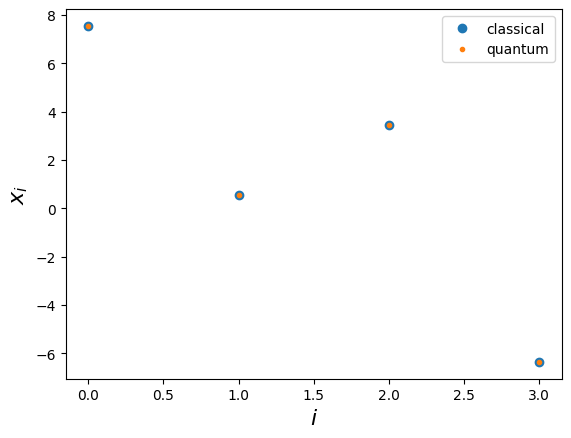

In [15]:
import matplotlib.pyplot as plt

plt.plot(expected_x, "o", label="classical")
plt.plot(computed_x, ".", label="quantum")
plt.xlabel(r"$i$", fontsize=16)
plt.ylabel(r"$x_i$", fontsize=16)
plt.legend();

In [16]:
assert (
    min(
        np.linalg.norm(computed_x - expected_x),
        np.linalg.norm(-computed_x - expected_x),
    )
    < 0.05
)

<h3 id="references">References</h3>
<ol>
  <li id="ref-grand">
    Martyn JM, Rossi ZM, Tan AK, Chuang IL. Grand unification of quantum algorithms. PRX Quantum 2, 040203. (2021).
    <!-- External links -->
    &nbsp;- &nbsp;
    <a href="https://journals.aps.org/prxquantum/abstract/10.1103/PRXQuantum.2.040203" target="_blank" rel="noopener noreferrer">DOI &#8599;</a>
 <li id="ref-childs">
    A. M. Childs, R. Kothari, and R. D. Somma. Quantum algorithm for systems of linear equations with exponentially improved dependence on precision. SIAM Journal on Computing 46, 1920–1950 (2017). 
    <!-- External links -->
    &nbsp;- &nbsp;
    <a href="https://arxiv.org/abs/1511.02306" target="_blank" rel="noopener noreferrer">arXiv&#8599;</a>
</ol>


## A note on efficient block-encoding, condition number, and complexity

An efficient block-encoding of a matrix $A$ means that the resources to construct the unitary $U_{A,s}$, as well as the scaling factor $s$, scales poly-logarithmically with the matrix dimension. This technical note concerns the latter point.

First, we note that an optimal value for the scaling factor $s$ is the maximal singular value $\sigma_{\max}$, namely $s\geq \sigma_{\max}$. This comes directly from the requirement that $||A/s||\leq 1$. For that reason, the effective condition number used throughout the demo, $\kappa = s/\sigma_{\min}$, is bounded from below by the actual condition number $\sigma_{\max}/\sigma_{\min}$.

Next, note that if $s$ scales linearly with the problem size, then the exponential speedup is lost. This is because the polynomial degree then scales as $O(N)$. In addition, the amplitude of the encoded solution scales the same (although it also depends on the input vector $|b\rangle$), which requires an additional amplitude amplification routine that adds a factor of $O(\sqrt{N})$ to the overall resources.
